# Tarea 3: Los K-vecinos 

## Introducción

<img src="vecinos.png" width="400">

Los $K$-vecinos es un método clásico y muy sencillo para hacer clasificación de datos, que se basa en predecir la etiqueta de un dato basado en las etiquetas de los datos de entrenamiento que más se le parecen. La siguiente figura describe graficamente los tres pasos del algoritmo

<img src="algoritmo.png" width="600">

En este caso es clave definir una noción de distancia entre los ejemplos y también especificar un valor adecuado para $K$, la cantidad de vecinos que influyen en la predicción.

## Formalismo matemático

Sea una base de datos $E = \{(x_j, y_j), j=1, \ldots, N\}$, con $N$ ejemplos donde $x_j \in \mathbb{R}^{D}$ es un atributo d-dimensional e $y_j \in \{0, 1, 2, \ldots, C-1\}$ son sus etiquetas de clase. Sea ahora una segunda base de datos $T = \{(z_i), i=1, \ldots, M\}$ con $M$ ejemplos donde $z_i \in \mathbb{R}^{D}$ es un atributo d-dimensional. Esta base de datos no tiene etiquetas. El objetivo es clasificar los ejemplos de $T$ en base a las etiquetas de los $K$ ejemplos más cercanos de la base de datos $E$


El algoritmo para clasificar el i-esimo elemento de Z es

**Paso 1** Calculamos la distancia entre $z_i$ y cada elemento de $E$ usando

$$
d(z_i, x_j) = \left ( \sum_{d=1}^D  |z_{id} - x_{jd}|^p \right)^{1/p}
$$

que se conoce como [distancia de Minkowski](https://en.wikipedia.org/wiki/Minkowski_distance). Para el caso $p=2$ se recupera la clásica distancia euclidiana.

**Paso 2** Buscamos las $k$ tuplas $(x_k^{(i)}, y_k^{(i)})$ con menor distancia a $z_i$

**Paso 3** Seleccionamos la clase de $z_i$ según

$$
\text{arg}\max_{c=0, 1, \ldots} \sum_{k=1}^K \frac{\mathbb{1}(c=y^{(i)}_k)}{d(z_i, x^{(i)}_k)}
$$

donde 

$$
\mathbb{1}(a=b) = \begin{cases} 1 & \text{si } a=b \\ 0 &  \text{si } a\neq b \end{cases}
$$

se conoce como función indicadora. Esta versión particular del algoritmo se conoce como clasificador de $k$ vecinos ponderado, ya que una menor distancia (mayor cercanía) aumenta el peso del voto

## Instrucciones generales 

1. Forme un grupo de **máximo tres estudiantes**
1. Versione su trabajo usando un **repositorio privado de github**. Agregue a sus compañeros y a su profesor (usuario github: phuijse) en la pestaña *Settings/Manage access*. No se aceptarán consultas de programación si no se cumple este requisito
1. Su tarea se evaluará en base al último commit antes de la fecha de entrega: **23:59 del Martes 20 de Julio de 2021**. La nota se calcula como ("pt totales" + 1)
1. [Sean leales y honestos](https://www.acm.org/about-acm/code-of-ethics-in-spanish), no copie ni comparta resultados con otros grupos

## Instrucciones de la actividad

- (1pt) Considere la implementación "ingenua" del algoritmo KNN que se adjunta a esta tarea con los parámetros $p$ y $k$ por defecto
    - Use la función adjunta `create_data` para crear un conjunto de `N=1000` datos
    - Realice un profiling completo de la función `KNN` usando las magias `timeit`, `prun` y `lprun`
    - Reporte sus resultados y comente sobre los cuellos de botella del algoritmo
- (2pt) Implemente una nueva versión de la función `KNN`
    - Utilice `Cython` con tipos fijos, vistas de arreglos y funciones de la librería estándar matemática de `C`
    - Muestre que obtiene el mismo resultado que la versión original
    - Grafique el *speed-up* de su nueva función con respecto a la implementación "inocente" original para $N=[10, 50, 100, 500, 1000, 5000, 10000]$
- (2pt) Usando la nueva versión de `KNN` y el conjunto de `N=1000` datos creados con `create_data` realice una validación cruzada en el conjunto $E$ para encontrar el mejor valor de los parámetros $k$ y $p$
- (1pt) Evalue su mejor clasificador en el conjunto $T$ y haga un reporte completo de resultados que incluya curvas ROC y las métricas vistas en el curso. Muestre una gráfica de la frontera de decisión de su clasificador en el rango $[(-2,2), (-2,2)]$

**Justifique adecuadamente todas sus decisiones de diseño**

A continuación se muestra una gráfica con los datos a utilizar en esta tarea

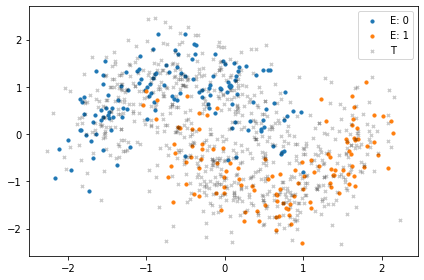

In [110]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from funciones import create_data, KNN

E, T = create_data(N=1000)
x, y = E # Use E para realizar validación cruzada
z, w = T # Use las etiquetas w para evaluar sus resultados finales

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
for c in np.unique(y):
    mask = y == c
    ax.scatter(x[mask, 0], x[mask, 1], label=f"E: {c}", s=10)
ax.scatter(z[:, 0], z[:, 1], c='k', s=10, marker='x',  alpha=0.2, label='T')
ax.legend();

# Desarrollo

In [111]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from funciones import create_data, KNN

## (1pt) Considere la implementación "ingenua" del algoritmo KNN que se adjunta a esta tarea con los parámetros $p$ y $k$ por defecto

    - Use la función adjunta `create_data` para crear un conjunto de `N=1000` datos
    - Realice un profiling completo de la función `KNN` usando las magias `timeit`, `prun` y `lprun`
    - Reporte sus resultados y comente sobre los cuellos de botella del algoritmo


In [117]:
E, T = create_data(N=1000)
x,y = E
z = T[0]

In [118]:
timeit = %timeit -r20 -q -o KNN(x,y,z)
prun = %prun -r -s cumtime KNN(x,y,z)
%load_ext line_profiler
lprun = %lprun -r -f KNN KNN(x,y,z)

 The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [119]:
print("timeit: ",timeit)

print("\n***prun***\n")
print(prun.print_stats())

print("\n***lprun***\n")
print(lprun.print_stats())

timeit:  1.69 s ± 35.1 ms per loop (mean ± std. dev. of 20 runs, 1 loop each)

***prun***

         1707777 function calls in 2.022 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    2.022    2.022 {built-in method builtins.exec}
        1    0.000    0.000    2.022    2.022 <string>:1(<module>)
        1    0.975    0.975    2.022    2.022 funciones.py:14(KNN)
   189000    0.087    0.000    1.038    0.000 <__array_function__ internals>:2(sum)
   189752    0.080    0.000    0.937    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   189000    0.173    0.000    0.848    0.000 fromnumeric.py:2111(sum)
   189000    0.191    0.000    0.651    0.000 fromnumeric.py:70(_wrapreduction)
   189000    0.375    0.000    0.375    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   189000    0.066    0.000    0.066    0.000 fromnumeric.py:71(<dictcomp>)
   189000    0.024    0.0

__Respuesta:__ 
* `timeit:` El tiempo promedio que tomó la ejecución de `KNN(x,y,z)` en 20 repeticiones da como resultado 1.61s.
* `prun:` Se puede ver el número de llamadas de 189000  en múltiples acciones.
* `lprun:` Se ve que en la línea 20 y 21 una cantidad elevada de llamadas, además de un tiempo elevado a comparación de las demás líneas. La acción que más toma tiempo eneste caso es la potencia `np.power(...)`.

## (2pt) Implemente una nueva versión de la función `KNN`

    - Utilice `Cython` con tipos fijos, vistas de arreglos y funciones de la librería estándar matemática de `C`
    - Muestre que obtiene el mismo resultado que la versión original
    - Grafique el *speed-up* de su nueva función con respecto a la implementación "inocente" original para $N=[10, 50, 100, 500, 1000, 5000, 10000]$

In [120]:
%load_ext cython 

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [128]:
%%cython -a -l m
import cython
import numpy as np
cimport numpy as npc

cdef extern from "math.h":
    float pow(float,float)
    float fabs(float)

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

def KNN_c(npc.float64_t [:, ::1] X, int [::1] Y, npc.float64_t [:, ::1] Z, int k = 5, npc.float64_t p = 2):
    C = np.unique(Y)
    cdef int [::1] C_view = C
    cdef int C_c = len(C_view)
    cdef int N = X.shape[0]
    cdef int D = X.shape[1]
    cdef int M = Z.shape[0]
    cdef npc.ndarray dist = np.zeros(shape=(M, N), dtype=float)
    cdef npc.float64_t [:, ::1] dist_view = dist
    cdef Py_ssize_t i, j, c
    for i in range(M):
        for j in range(N):
            for l in range(D): dist_view[i, j] += pow(fabs(Z[i, l] - X[j, l]), p)
            dist_view[i, j] =  pow(dist_view[i, j], 1./p)
    cdef npc.ndarray neighbours = np.ascontiguousarray(np.argsort(dist, axis=1)[:,:k],dtype=np.int32)
    cdef int [:, ::1] neighbours_view = neighbours
    cdef npc.ndarray Z_Y = np.zeros(shape=(M, ),dtype=np.float64)
    cdef npc.float64_t [::1] Z_Y_view = Z_Y
    cdef npc.ndarray criterion = np.zeros(shape=(C_c,))
    cdef npc.float64_t [::1] criterion_view = criterion
    cdef npc.float64_t maximo = 0
    cdef int arg_maximo = 0
    for i in range(M):
        for j in range(C_c): criterion_view[j] = 0
        for c in range(C_c):
            for l in range(k):
                if (Y[neighbours_view[i,l]] == c): criterion_view[c] += 1/dist_view[i, neighbours_view[i,l]] 
            if (criterion_view[c])> maximo:
                arg_maximo = c
                maximo = criterion_view[c]
        Z_Y_view[i] = arg_maximo
        arg_maximo = 0
        maximo = 0
    return Z_Y

In [129]:
E, T = create_data(N=1000)
x,y = E
z = T[0]

x_d = x.astype(np.float64)
y_d = y.astype(np.int32)
z_d = z.astype(np.float64)

display(np.allclose(KNN(x,y,z),KNN_c(x_d,y_d,z_d)))

timeit_python = %timeit -r10 -q -o KNN(x,y,z)
timeit_cython = %timeit -r10 -q -o KNN_c(x_d,y_d,z_d)

print("Tiempo Python: ", timeit_python)
print("Tiempo Cython: ", timeit_cython)
print("Diferencia: ", timeit_python.average-timeit_cython.average, "s")

True

Tiempo Python:  1.67 s ± 60.4 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
Tiempo Cython:  21.4 ms ± 2.02 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)
Diferencia:  1.6490341748417994 s


__Respuesta:__
* El display indica `True`, por lo tanto los resultados entregados son los mismos.
* Se puede ver la notable diferencia existente entre ejecutar un código con python y otro con C (utilizando Cython). 

In [99]:
def i_time(n):  
    E, T = create_data(n)
    x,y = E
    z = T[0]
    
    x_d = x.astype(np.float64)
    y_d = y.astype(np.int32)
    z_d = z.astype(np.float64)
    
    r1 = %timeit -r1 -n1 -o KNN(x,y,z)
    r2 = %timeit -r1 -n1 -o KNN_c(x_d,y_d,z_d)
    return r1.average,r2.average

def make_speed_up(time):
    s_u = np.zeros(shape=(time.shape[0]), dtype=np.double)
    for i in range(time.shape[0]): s_u[i] = time[i,0]/time[i,1]
    return s_u

In [12]:
N = np.array([10,50,100,500,1000,5000,10000])
time = np.zeros(shape=(N.shape[0],2), dtype=np.double)
for i,n in enumerate(N): time[i] = i_time(n)
speed_up = make_speed_up(time)

2.31 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
334 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
18.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
570 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
22.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
248 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
450 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4.81 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
21.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
40.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
580 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2min 38s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.43 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<IPython.core.display.Javascript object>


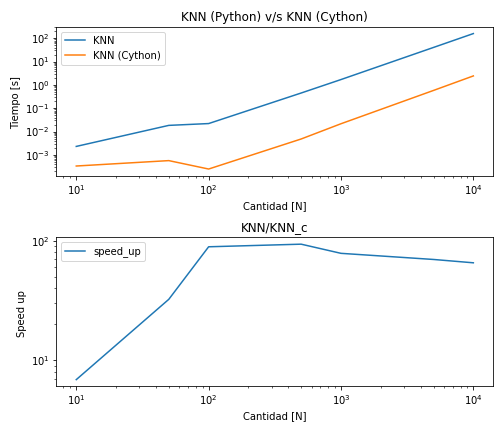

In [109]:
fig ,ax = plt.subplots(nrows = 2,ncols = 1, figsize = (7,6),tight_layout=True)

ax[0].set_title('KNN (Python) v/s KNN (Cython)')
ax[0].plot(N,time[:,0],label='KNN')
ax[0].plot(N,time[:,1],label='KNN (Cython)')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('Cantidad [N]')
ax[0].set_ylabel('Tiempo [s] ')
ax[0].legend()

ax[1].plot(N,speed_up,label='speed_up')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Cantidad [N]')
ax[1].set_ylabel('Speed up ')
ax[1].set_title('KNN/KNN_c')
ax[1].legend()

__R:__
* 

## (2pt) Usando la nueva versión de `KNN` y el conjunto de `N=1000` datos creados con `create_data` realice una validación cruzada en el conjunto $E$ para encontrar el mejor valor de los parámetros $k$ y $p$

In [113]:
def correctitud(v,d):
    N = 1000
    E, T = create_data(N)
    x,y = E
    z,w = T
    x = x.astype(np.float64)
    y = y.astype(np.int32)
    z = z.astype(np.float64)

    kf = KFold(n_splits=10)

    total = np.zeros(shape=(v,d))
    for k_vecinos in range(1, v):
        for p_distancia in range(1,d):
            score = np.zeros(shape=(kf.get_n_splits(), ))
            for i, (train_index, valid_index) in enumerate(kf.split(x)):
                w_pred = KNN_c(x[train_index],y[train_index],z,k_vecinos,p_distancia)
                c = 0
                for j,k in enumerate(w_pred): if w[j] == k: c+=1     
                score[i] = c/w.shape[0]
            total[k_vecinos,p_distancia] = np.amax(score)
    return total

In [115]:
total = correctitud(20,10)
k,p = [x[0] for x in np.where(total == total.max())]

print("Correctitud:", total.max())
print("Error:", 1-total.max())
print("k:", k)
print("p:", p)

Correctitud: 0.9573333333333334
Error: 0.04266666666666663
k: 13
p: 5


<IPython.core.display.Javascript object>


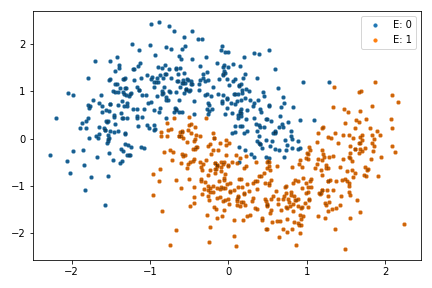

In [116]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from funciones import create_data, KNN

E, T = create_data(N=1000)
x, y = E 
z, w = T 

x = x.astype(np.float64)
y = y.astype(np.int32)
z = z.astype(np.float64)

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
for c in np.unique(y):
    mask = KNN_c(x,y,z,k,p) == c
    ax.scatter(z[mask, 0], z[mask, 1], label=f"E: {c}", s=10)
ax.scatter(z[:, 0], z[:, 1], c='k', s=10, marker='x',  alpha=0.2)
ax.legend();

# (1pt) Evalue su mejor clasificador en el conjunto $T$ y haga un reporte completo de resultados que incluya curvas ROC y las métricas vistas en el curso. Muestre una gráfica de la frontera de decisión de su clasificador en el rango $[(-2,2), (-2,2)]$